In [1]:
import torch
import numpy
import torch.nn.functional as F


N = 10000
idx_split = int(.8 * N)
d_in = 64
d_out = 64

ranks = [0] + [2**i for i in range(0, 7)]
X = torch.randn((N, d_in))

In [4]:
import torch
import numpy as np
import torch.nn.functional as F

# -----------------------------
# Data
# -----------------------------
N = 10000
idx_split = int(.8 * N)
d_in = 64
d_out = 64

ranks = [0] + [2**i for i in range(0, 7)]  # 0,1,2,4,8,16,32,64
X = torch.randn((N, d_in))

# full-rank teacher, base W0 = 0
W_star = torch.randn((d_out, d_in))
Y = X @ W_star.T

x_train, y_train = X[:idx_split], Y[:idx_split]
x_test,  y_test  = X[idx_split:], Y[idx_split:]

W_0 = torch.zeros((d_out, d_in), requires_grad=False)

# -----------------------------
# Theory: best rank-r approx error of Δ* = W* - W0
# -----------------------------
with torch.no_grad():
    Delta_star = W_star - W_0  # here: W_star
    # Singular values of the true required update
    s_star = torch.linalg.svdvals(Delta_star)  # shape (min(d_out,d_in),)
    # Precompute tail Frobenius^2 error for best rank-r approximation:
    # ||Δ* - (Δ*)_r||_F^2 = sum_{i>r} s_i^2
    s2 = (s_star ** 2).cpu().numpy()
    # suffix sums of squared singular values
    suffix_sums = np.cumsum(s2[::-1])[::-1]  # suffix_sums[i] = sum_{j>=i} s2[j]

def best_rank_r_fro_error_sq(r: int) -> float:
    # r can be 0..min(d_out, d_in)
    m = s_star.numel()
    if r <= 0:
        return float(suffix_sums[0]) if m > 0 else 0.0
    if r >= m:
        return 0.0
    return float(suffix_sums[r])

# -----------------------------
# Training config
# -----------------------------
num_steps = 5000
log_every = 100
lr = 1e-2

rank_dict = {}

print("True Δ* singular values (top 10):", s_star[:10].detach().cpu().numpy())
print("||Δ*||_F^2:", float(torch.sum(s_star**2).item()))

for r in ranks:
    # --- rank-0 baseline: no adapters, no training ---
    if r == 0:
        with torch.no_grad():
            y_hat_tr = x_train @ W_0.T
            y_hat_te = x_test  @ W_0.T
            tr_loss = F.mse_loss(y_hat_tr, y_train).item()
            te_loss = F.mse_loss(y_hat_te, y_test).item()

        # theory: best rank-0 approx to Δ* is 0, so error is ||Δ*||_F^2
        theory_err_sq = best_rank_r_fro_error_sq(0)

        rank_dict[r] = {
            "train_loss": tr_loss,
            "test_loss": te_loss,
            "deltaW_fro": 0.0,
            "theory_best_rank_r_fro_err_sq": theory_err_sq,
            "learned_deltaW_singular_values": np.array([]),
            "true_delta_star_singular_values": s_star.detach().cpu().numpy(),
            "log": [(0, tr_loss, te_loss, 0.0)],
        }
        print(
            f"[r=0] step=0 train={tr_loss:.6g} test={te_loss:.6g} "
            f"||ΔW||={0.0:.6g} theory_err_sq={theory_err_sq:.6g}"
        )
        continue

    # --- LoRA factors ---
    B = torch.zeros((d_out, r), requires_grad=True)  # init B=0 => ΔW=0 at start
    A = torch.randn((r, d_in), requires_grad=True)

    optim = torch.optim.Adam([A, B], lr=lr)
    logs = []

    # theory bound for this rank (in weight space)
    theory_err_sq = best_rank_r_fro_error_sq(r)

    for step in range(1, num_steps + 1):
        W_eff = W_0 + (B @ A)                 # (d_out, d_in)
        y_hat = x_train @ W_eff.T             # (N_train, d_out)
        loss = F.mse_loss(y_hat, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if step % log_every == 0 or step == 1 or step == num_steps:
            with torch.no_grad():
                DeltaW = (B @ A)
                y_hat_te = x_test @ (W_0 + DeltaW).T
                test_loss = F.mse_loss(y_hat_te, y_test).item()
                train_loss = loss.item()
                deltaW_fro = torch.linalg.norm(DeltaW, ord="fro").item()
            logs.append((step, train_loss, test_loss, deltaW_fro))
            print(
                f"[r={r}] step={step:5d} train={train_loss:.6g} test={test_loss:.6g} "
                f"||ΔW||={deltaW_fro:.6g} theory_err_sq={theory_err_sq:.6g}"
            )

    # final singular values of learned ΔW
    with torch.no_grad():
        DeltaW = (B @ A)
        s_learned = torch.linalg.svdvals(DeltaW).detach().cpu().numpy()

    with torch.no_grad():
        DeltaW = B @ A
        achieved_residual_fro_sq = torch.linalg.norm((W_star - W_0) - DeltaW, ord="fro").item()**2

    rank_dict[r] = {
        "train_loss": logs[-1][1],
        "test_loss": logs[-1][2],
        "deltaW_fro": logs[-1][3],
        "theory_best_rank_r_fro_err_sq": theory_err_sq,
        "learned_deltaW_singular_values": s_learned,
        "true_delta_star_singular_values": s_star.detach().cpu().numpy(),
        "log": logs,
        "achieved_residual_fro_sq": achieved_residual_fro_sq
    }

True Δ* singular values (top 10): [15.078651 14.812166 14.453455 14.073301 13.735828 13.530882 13.259381
 13.033898 12.675182 12.058874]
||Δ*||_F^2: 4167.376953125
[r=0] step=0 train=65.324 test=64.6429 ||ΔW||=0 theory_err_sq=4167.38
[r=1] step=    1 train=65.324 test=64.5175 ||ΔW||=0.680886 theory_err_sq=3940.01
[r=1] step=  100 train=62.4853 test=61.8984 ||ΔW||=13.2702 theory_err_sq=3940.01
[r=1] step=  200 train=61.8393 test=61.2459 ||ΔW||=14.7823 theory_err_sq=3940.01
[r=1] step=  300 train=61.7458 test=61.1207 ||ΔW||=14.9786 theory_err_sq=3940.01
[r=1] step=  400 train=61.7277 test=61.0917 ||ΔW||=15.0217 theory_err_sq=3940.01
[r=1] step=  500 train=61.7242 test=61.0882 ||ΔW||=15.0306 theory_err_sq=3940.01
[r=1] step=  600 train=61.7232 test=61.0908 ||ΔW||=15.0319 theory_err_sq=3940.01
[r=1] step=  700 train=61.7227 test=61.0943 ||ΔW||=15.0314 theory_err_sq=3940.01
[r=1] step=  800 train=61.7225 test=61.0973 ||ΔW||=15.0305 theory_err_sq=3940.01
[r=1] step=  900 train=61.7224 test=6

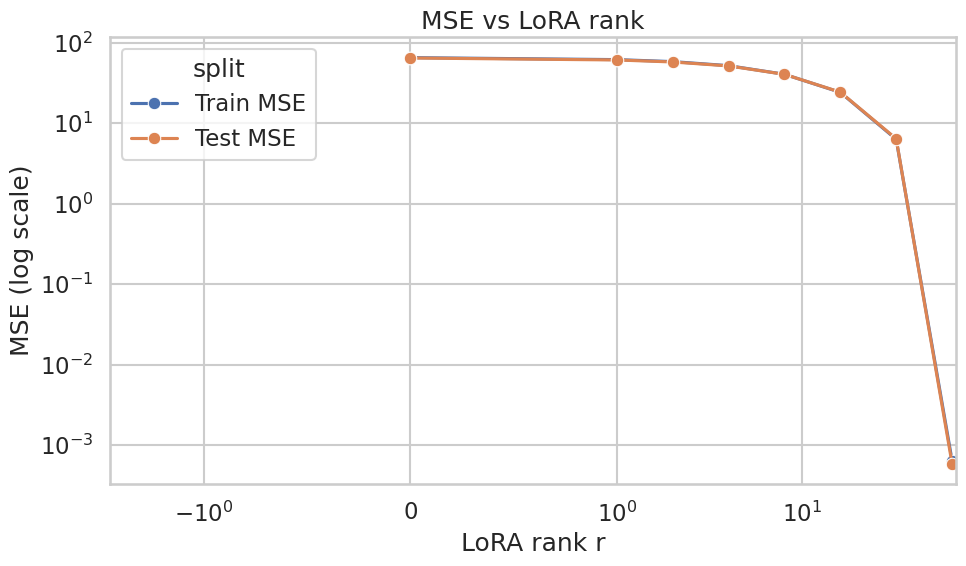

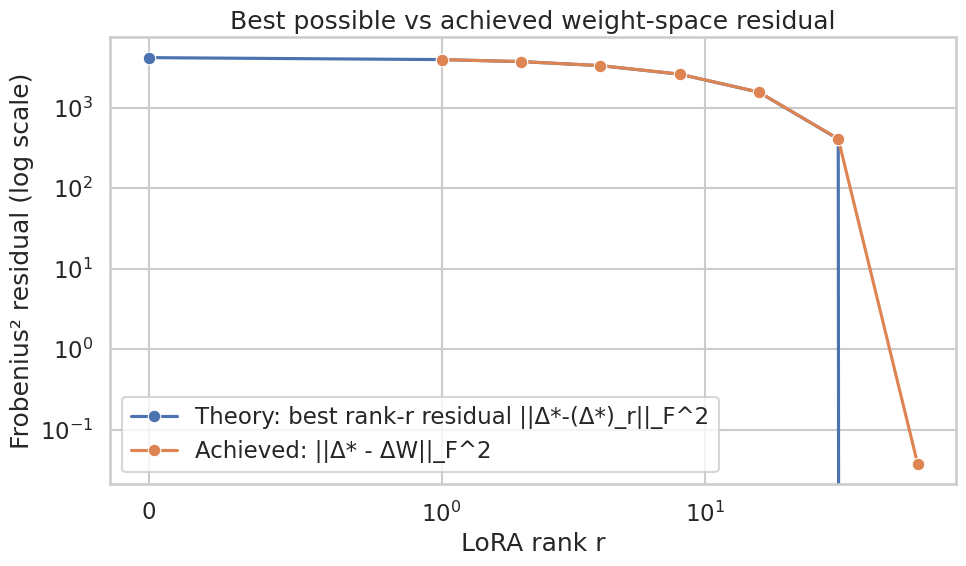

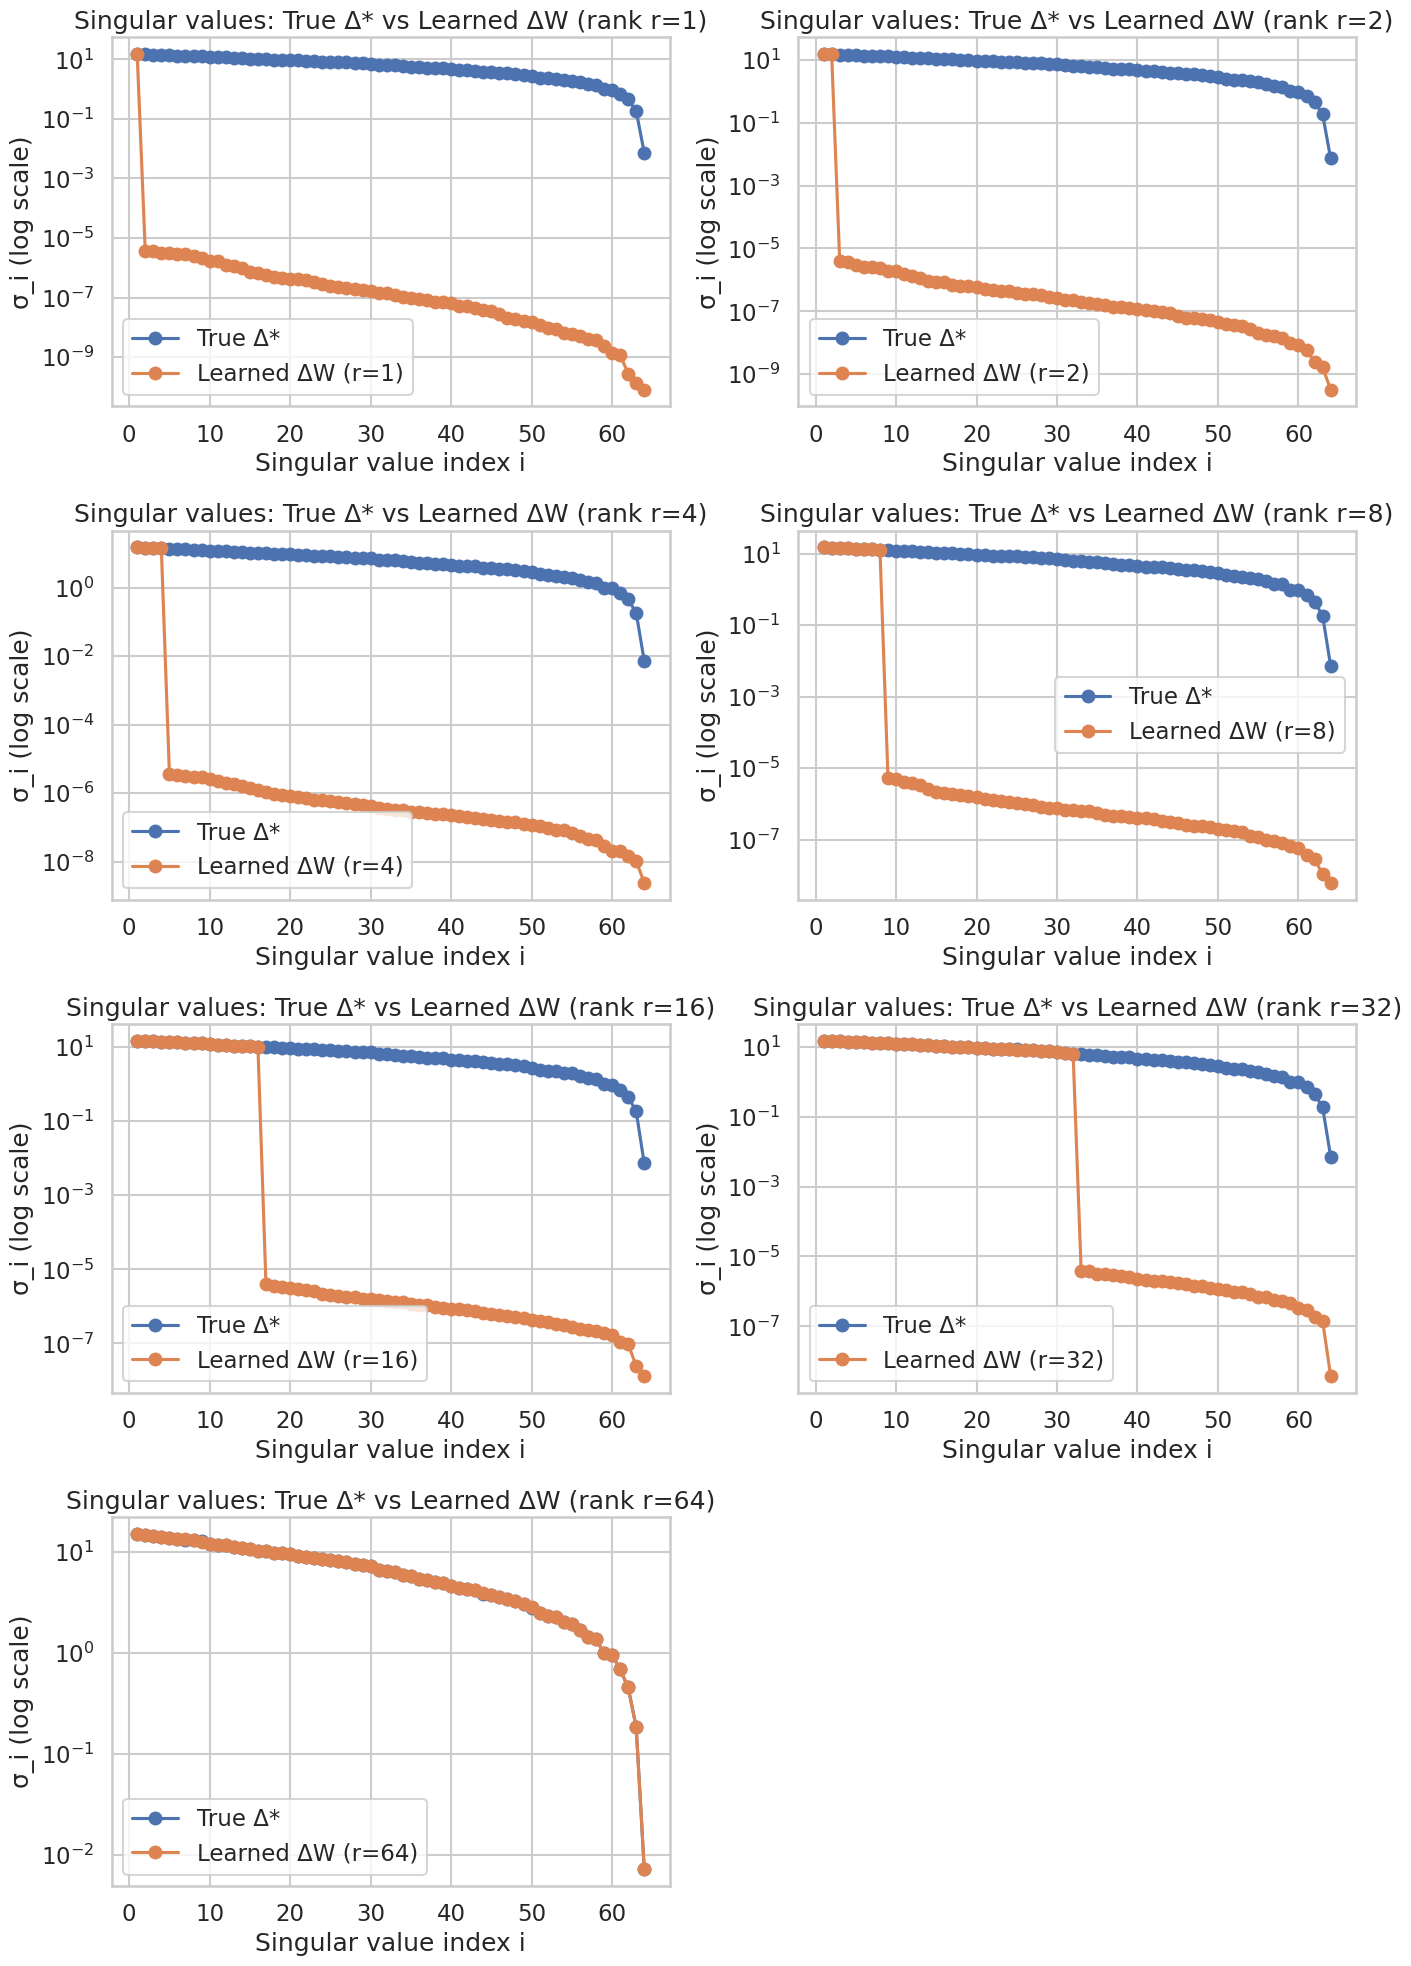

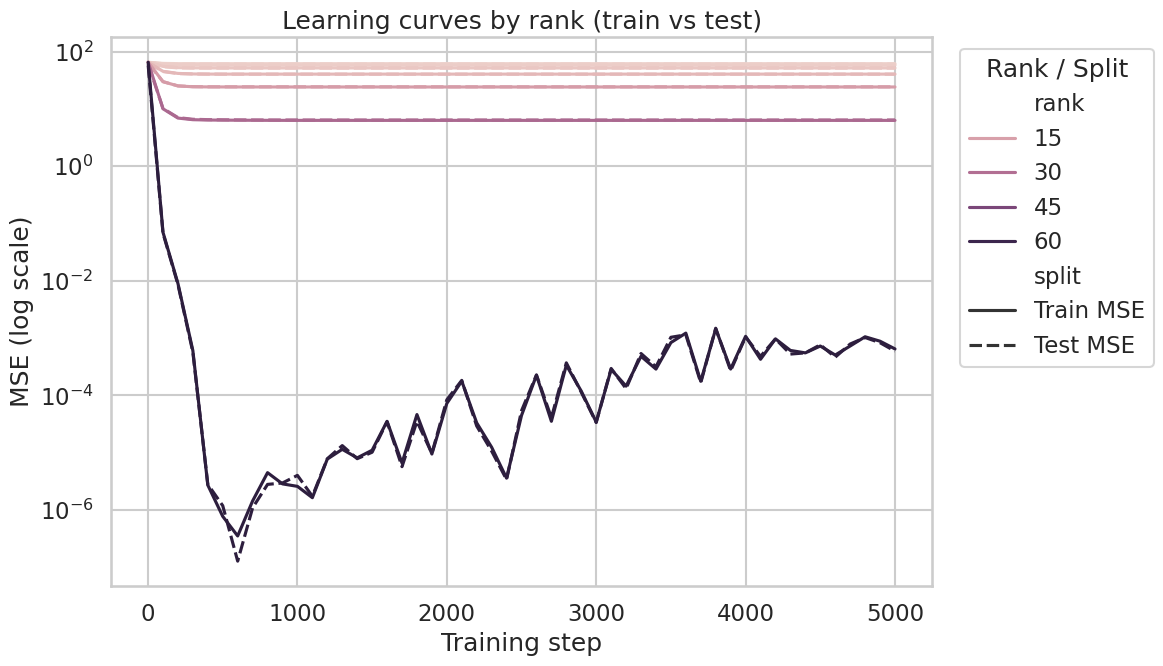

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

# -----------------------------
# Helpers to extract arrays
# -----------------------------
def get_true_singular_values(rank_dict):
    # stored redundantly per-rank; just grab from any key
    any_key = next(iter(rank_dict.keys()))
    return np.array(rank_dict[any_key]["true_delta_star_singular_values"], dtype=float)

s_star = get_true_singular_values(rank_dict)
Delta_star_fro_sq = float(np.sum(s_star**2))

# (Optional but recommended) compute achieved weight-space residuals if you still have A,B around.
# If you don't, you can store them, OR compute these inside the training loop and save into rank_dict.
#
# For now, we'll compute achieved residuals using the singular values if you've stored learned DeltaW singular values.
# NOTE: This gives ||DeltaW||_F^2, not ||Delta* - DeltaW||_F^2.
# To get the actual residual ||Delta* - DeltaW||_F^2 you must compute it directly and store it during training.
#
# We'll plot:
#   - theory residual (best possible)
#   - and (if available) achieved residual you stored explicitly as `achieved_residual_fro_sq`
#
# If you haven't stored achieved_residual_fro_sq yet, see snippet at the bottom.

# -----------------------------
# Build a compact summary table
# -----------------------------
rows = []
for r, d in rank_dict.items():
    rows.append({
        "rank": int(r),
        "train_mse": float(d["train_loss"]),
        "test_mse": float(d["test_loss"]),
        "deltaW_fro": float(d["deltaW_fro"]),
        "theory_residual_fro_sq": float(d["theory_best_rank_r_fro_err_sq"]),
        # if you added this (recommended) it will appear; otherwise NaN
        "achieved_residual_fro_sq": float(d.get("achieved_residual_fro_sq", np.nan)),
    })
df = pd.DataFrame(rows).sort_values("rank").reset_index(drop=True)

# Convenient: log2(rank) for nicer x-axis spacing with powers of two
df["rank_label"] = df["rank"].astype(str)
df["log2_rank"] = df["rank"].replace(0, np.nan).apply(lambda x: np.log2(x) if pd.notnull(x) else np.nan)

# -----------------------------
# Plot 1: Train/Test MSE vs rank
# -----------------------------
plt.figure(figsize=(10, 6))
df_melt = df.melt(id_vars=["rank"], value_vars=["train_mse", "test_mse"],
                  var_name="split", value_name="mse")

# Make split labels nicer
df_melt["split"] = df_melt["split"].map({"train_mse": "Train MSE", "test_mse": "Test MSE"})

ax = sns.lineplot(data=df_melt, x="rank", y="mse", hue="split", marker="o")
ax.set_xscale("symlog", linthresh=1)  # nice for including rank=0
ax.set_yscale("log")
ax.set_xlabel("LoRA rank r")
ax.set_ylabel("MSE (log scale)")
ax.set_title("MSE vs LoRA rank")
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: Theory best rank-r residual vs achieved residual (if available)
# -----------------------------
plt.figure(figsize=(10, 6))

# Theory curve
ax = sns.lineplot(data=df, x="rank", y="theory_residual_fro_sq", marker="o", label="Theory: best rank-r residual ||Δ*-(Δ*)_r||_F^2")

# Achieved residual curve if you stored it
if df["achieved_residual_fro_sq"].notna().any():
    sns.lineplot(data=df, x="rank", y="achieved_residual_fro_sq", marker="o",
                 label="Achieved: ||Δ* - ΔW||_F^2")

ax.set_xscale("symlog", linthresh=1)
ax.set_yscale("log")
ax.set_xlabel("LoRA rank r")
ax.set_ylabel("Frobenius² residual (log scale)")
ax.set_title("Best possible vs achieved weight-space residual")
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 3: Singular values — true Δ* vs learned ΔW for each rank
# -----------------------------
# Build a long-form DF: for each rank, list singular values of learned ΔW
sv_rows = []

# True Δ* singular values (same for all ranks) — include once for overlay
true_df = pd.DataFrame({
    "rank": -1,
    "i": np.arange(1, len(s_star) + 1),
    "singular_value": s_star,
    "type": "True Δ*"
})

for r, d in rank_dict.items():
    if r == 0:
        continue
    s_learned = np.array(d["learned_deltaW_singular_values"], dtype=float)
    # sort descending just in case
    s_learned = np.sort(s_learned)[::-1]
    sv_rows.append(pd.DataFrame({
        "rank": int(r),
        "i": np.arange(1, len(s_learned) + 1),
        "singular_value": s_learned,
        "type": f"Learned ΔW (r={r})"
    }))

learned_df = pd.concat(sv_rows, ignore_index=True) if sv_rows else pd.DataFrame(columns=["rank","i","singular_value","type"])

# Plot a "small multiples" style: one plot per rank, overlay true vs learned
# (Looks good and makes the rank-cap obvious)
unique_ranks = sorted([r for r in rank_dict.keys() if r != 0])
ncols = 2
nrows = int(np.ceil(len(unique_ranks) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 5*nrows), squeeze=False)
axes = axes.flatten()

for ax, r in zip(axes, unique_ranks):
    d = rank_dict[r]
    s_learned = np.sort(np.array(d["learned_deltaW_singular_values"], dtype=float))[::-1]

    # Plot true Δ*
    ax.plot(np.arange(1, len(s_star) + 1), s_star, marker="o", linestyle="-", label="True Δ*")

    # Plot learned ΔW
    ax.plot(np.arange(1, len(s_learned) + 1), s_learned, marker="o", linestyle="-", label=f"Learned ΔW (r={r})")

    ax.set_yscale("log")
    ax.set_xlabel("Singular value index i")
    ax.set_ylabel("σ_i (log scale)")
    ax.set_title(f"Singular values: True Δ* vs Learned ΔW (rank r={r})")
    ax.legend()

# Hide unused axes
for ax in axes[len(unique_ranks):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# -----------------------------
# Plot 4 (Optional): Learning curves (train/test) vs steps, per rank
# -----------------------------
lc_rows = []
for r, d in rank_dict.items():
    for entry in d["log"]:
        step, train_loss, test_loss, deltaW_fro = entry
        lc_rows.append({"rank": int(r), "step": int(step), "train_mse": float(train_loss), "test_mse": float(test_loss), "deltaW_fro": float(deltaW_fro)})

lc = pd.DataFrame(lc_rows)

# Melt for seaborn
lc_melt = lc.melt(id_vars=["rank", "step"], value_vars=["train_mse", "test_mse"],
                  var_name="split", value_name="mse")
lc_melt["split"] = lc_melt["split"].map({"train_mse": "Train MSE", "test_mse": "Test MSE"})

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=lc_melt[lc_melt["rank"] != 0], x="step", y="mse", hue="rank", style="split")
ax.set_yscale("log")
ax.set_xlabel("Training step")
ax.set_ylabel("MSE (log scale)")
ax.set_title("Learning curves by rank (train vs test)")
plt.legend(title="Rank / Split", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F

# -----------------------------
# Data
# -----------------------------
N = 10000
idx_split = int(.8 * N)
d_in = 64
d_out = 64

ranks = [0] + [2**i for i in range(0, 7)]  # 0,1,2,4,8,16,32,64
X = torch.randn((N, d_in))

# full-rank teacher, base W0 = 0
W_star = torch.randn((d_out, d_in))
Y = X @ W_star.T

x_train, y_train = X[:idx_split], Y[:idx_split]
x_test,  y_test  = X[idx_split:], Y[idx_split:]

W_0 = torch.zeros((d_out, d_in), requires_grad=False)

# -----------------------------
# Theory: best rank-r approx error of Δ* = W* - W0
# -----------------------------
with torch.no_grad():
    Delta_star = W_star - W_0  # here: W_star
    # Singular values of the true required update
    s_star = torch.linalg.svdvals(Delta_star)  # shape (min(d_out,d_in),)
    # Precompute tail Frobenius^2 error for best rank-r approximation:
    # ||Δ* - (Δ*)_r||_F^2 = sum_{i>r} s_i^2
    s2 = (s_star ** 2).cpu().numpy()
    # suffix sums of squared singular values
    suffix_sums = np.cumsum(s2[::-1])[::-1]  # suffix_sums[i] = sum_{j>=i} s2[j]

def best_rank_r_fro_error_sq(r: int) -> float:
    # r can be 0..min(d_out, d_in)
    m = s_star.numel()
    if r <= 0:
        return float(suffix_sums[0]) if m > 0 else 0.0
    if r >= m:
        return 0.0
    return float(suffix_sums[r])

# -----------------------------
# Training config
# -----------------------------
num_steps = 5000
log_every = 100
lr = 1e-2

rank_dict = {}

print("True Δ* singular values (top 10):", s_star[:10].detach().cpu().numpy())
print("||Δ*||_F^2:", float(torch.sum(s_star**2).item()))

for r in ranks:
    # --- rank-0 baseline: no adapters, no training ---
    if r == 0:
        with torch.no_grad():
            y_hat_tr = x_train @ W_0.T
            y_hat_te = x_test  @ W_0.T
            tr_loss = F.mse_loss(y_hat_tr, y_train).item()
            te_loss = F.mse_loss(y_hat_te, y_test).item()

        # theory: best rank-0 approx to Δ* is 0, so error is ||Δ*||_F^2
        theory_err_sq = best_rank_r_fro_error_sq(0)

        rank_dict[r] = {
            "train_loss": tr_loss,
            "test_loss": te_loss,
            "deltaW_fro": 0.0,
            "theory_best_rank_r_fro_err_sq": theory_err_sq,
            "learned_deltaW_singular_values": np.array([]),
            "true_delta_star_singular_values": s_star.detach().cpu().numpy(),
            "log": [(0, tr_loss, te_loss, 0.0)],
        }
        print(
            f"[r=0] step=0 train={tr_loss:.6g} test={te_loss:.6g} "
            f"||ΔW||={0.0:.6g} theory_err_sq={theory_err_sq:.6g}"
        )
        continue

    # --- LoRA factors ---
    B = torch.zeros((d_out, r), requires_grad=True)  # init B=0 => ΔW=0 at start
    A = torch.randn((r, d_in), requires_grad=True)

    optim = torch.optim.Adam([A, B], lr=lr)
    logs = []

    # theory bound for this rank (in weight space)
    theory_err_sq = best_rank_r_fro_error_sq(r)

    for step in range(1, num_steps + 1):
        W_eff = W_0 + (B @ A)                 # (d_out, d_in)
        y_hat = x_train @ W_eff.T             # (N_train, d_out)
        loss = F.mse_loss(y_hat, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if step % log_every == 0 or step == 1 or step == num_steps:
            with torch.no_grad():
                DeltaW = (B @ A)
                y_hat_te = x_test @ (W_0 + DeltaW).T
                test_loss = F.mse_loss(y_hat_te, y_test).item()
                train_loss = loss.item()
                deltaW_fro = torch.linalg.norm(DeltaW, ord="fro").item()
            logs.append((step, train_loss, test_loss, deltaW_fro))
            print(
                f"[r={r}] step={step:5d} train={train_loss:.6g} test={test_loss:.6g} "
                f"||ΔW||={deltaW_fro:.6g} theory_err_sq={theory_err_sq:.6g}"
            )

    # final singular values of learned ΔW
    with torch.no_grad():
        DeltaW = (B @ A)
        s_learned = torch.linalg.svdvals(DeltaW).detach().cpu().numpy()

    with torch.no_grad():
        DeltaW = B @ A
        achieved_residual_fro_sq = torch.linalg.norm((W_star - W_0) - DeltaW, ord="fro").item()**2

    rank_dict[r] = {
        "train_loss": logs[-1][1],
        "test_loss": logs[-1][2],
        "deltaW_fro": logs[-1][3],
        "theory_best_rank_r_fro_err_sq": theory_err_sq,
        "learned_deltaW_singular_values": s_learned,
        "true_delta_star_singular_values": s_star.detach().cpu().numpy(),
        "log": logs,
        "achieved_residual_fro_sq": achieved_residual_fro_sq
    }